<a href="https://colab.research.google.com/github/JessicaaaJe/User-Behavior-Analysis-Using-Clustering/blob/main/Cluster_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clustering Analysis Project

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd


import numpy as np


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns





## **part A**

*** ------------- functions ---------- ***

In [ ]:
def scale_data(data_matrix):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_matrix)
    return scaled_data, scaler

In [ ]:
def init_cluster_centers(data_mat, k):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=1, random_state=42)
    kmeans.fit(data_mat)
    return kmeans.cluster_centers_

In [ ]:
def euclidean_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

In [ ]:
def k_means_373(data_mat, k, initial_centers, max_iters=100, tol=1e-4):

    data_mat = np.array(data_mat)
    centroids = np.array(initial_centers)
    prev_centroids = np.zeros(initial_centers.shape)
    labels = np.zeros(len(data_mat))

    for iteration in range(max_iters):
        # Assignment Step
        clusters_populated = set()  # Keep track of clusters that have points assigned
        for i, point in enumerate(data_mat):
            distances = [euclidean_distance(point, centroid) for centroid in centroids]
            assigned_cluster = np.argmin(distances)
            labels[i] = assigned_cluster
            clusters_populated.add(assigned_cluster)

        # Save old centroids for convergence check
        prev_centroids = centroids.copy()

        # Update Step
        for i in range(k):
            if i in clusters_populated:  # Only update centroids for clusters with assigned points
                centroids[i] = np.mean(data_mat[labels == i], axis=0)
            else:  # Handle the case where a cluster has no points assigned
                # Reinitialize the cluster centroid to a random data point
                centroids[i] = data_mat[np.random.choice(data_mat.shape[0])]

        # Convergence check
        if np.sum((centroids - prev_centroids)**2) < tol:
            break

    return centroids, labels


In [ ]:
def intracluster_dist(data_mat, k, cluster_assignments, cluster_centers):
    intra_distances = []
    for cluster in range(k):
        distances = np.linalg.norm(data_mat[cluster_assignments == cluster] - cluster_centers[cluster], axis=1)
        intra_distances.append(np.mean(distances))
    return intra_distances

In [ ]:
def intercluster_dist(c1, c2, cluster_centers):
    return np.linalg.norm(cluster_centers[c1] - cluster_centers[c2])

In [ ]:
# silhouette_score function
def compute_silhouette_score(X, labels):
    # Number of clusters
    n_clusters = len(set(labels))
    if n_clusters == 1:
        return -1

    silhouette_vals = []
    for i, label in enumerate(labels):
        # Compute a(i)
        intra_cluster_points = X[labels == label]
        intra_distance = np.mean([np.linalg.norm(x - X[i]) for x in intra_cluster_points if not np.array_equal(x, X[i])])

        # Compute b(i)
        inter_cluster_distances = []
        for other_cluster in set(labels):
            if other_cluster != label:
                inter_cluster_points = X[labels == other_cluster]
                inter_cluster_distances.append(np.mean([np.linalg.norm(x - X[i]) for x in inter_cluster_points]))

        b_i = min(inter_cluster_distances)

        # Compute Silhouette value for this data point
        s_i = (b_i - intra_distance) / max(b_i, intra_distance)
        silhouette_vals.append(s_i)

    return np.mean(silhouette_vals)


**-------------------------Check the Data-----------------------------------**

The Ecommerce dataset has 500 observations and 5 features: Average Session Length, Time on App, Length of Membership, Yearly Amount Spent.

In [ ]:

# File path
file_path = "/content/drive/MyDrive/share_folders_csc373/Data/Ecommerce_Customer.csv"

# Read the file
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to confirm
df.head()



,Unnamed: 0,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,0,34.497268,12.655651,39.577668,4.082621,587.951054
1,1,31.926272,11.109461,37.268959,2.664034,392.204933
2,2,33.000915,11.330278,37.110597,4.104543,487.547505
3,3,34.305557,13.717514,36.721283,3.120179,581.852344
4,4,33.330673,12.795189,37.536653,4.446308,599.406092


In [ ]:
num_rows = df.shape[0]
print(f"The number of rows in the dataset is: {num_rows}")

The number of rows in the dataset is: 500


For each K, those statistics are evaluated:
intra-cluster distance for each cluster
average intra-cluster distance
inter-cluster distance for each pair of clusters
average inter-cluster distance
silhouette score


It is really interesting to find that when only two features included (length of membership, and yearly amount spent), the clustering give the best performance. I will further discuss that in the report.

*** --------- testing with different parameters -----------------***

In [ ]:
df = df.iloc[:, [1,4,5]]
# Using the functions
df_scaled, scaler = scale_data(df)

statistics = {}

for k in range(2, 8):
    initial_centers = init_cluster_centers(df_scaled, k)
    final_centers, cluster_assignments = k_means_373(df_scaled, k, initial_centers)

    statistics[k] = {
        "Labels": cluster_assignments,
        "Initial Cluster Centers": scaler.inverse_transform(initial_centers),
        "Final Cluster Centers": scaler.inverse_transform(final_centers),
        "Intra-cluster Distances": intracluster_dist(df_scaled, k, cluster_assignments, final_centers),
        "Average Intra-cluster Distance": np.mean(intracluster_dist(df_scaled, k, cluster_assignments, final_centers)),
        "Inter-cluster Distances": [intercluster_dist(cluster_i, cluster_j, final_centers)
                                    for cluster_i in range(k)
                                    for cluster_j in range(cluster_i + 1, k)],
        "Average Inter-cluster Distance": np.mean([intercluster_dist(cluster_i, cluster_j, final_centers)
                                                  for cluster_i in range(k)
                                                  for cluster_j in range(cluster_i + 1, k)]),
        "Silhouette Score": compute_silhouette_score(df_scaled, cluster_assignments)
    }

# Print the stored statistics
for k, stats in statistics.items():
    print(f"\nFor k = {k}:")
    print(f"\nInitial Cluster Centers: \n{stats['Initial Cluster Centers']}")
    print(f"\nFinal Cluster Centers: \n{stats['Final Cluster Centers']}")

    print("\nIntra-cluster distances:")
    for cluster, distance in enumerate(stats['Intra-cluster Distances']):
        print(f"Distance for Cluster {cluster}: {distance:.3f}")
    print(f"Average intra-cluster distance: {stats['Average Intra-cluster Distance']:.3f}")

    print("\nInter-cluster distances:")
    for idx, distance in enumerate(stats['Inter-cluster Distances']):
        cluster_i = idx // (k - 1)
        cluster_j = (idx % (k - 1)) + cluster_i + 1
        print(f"Distance between Cluster {cluster_i} and Cluster {cluster_j}: {distance:.3f}")
    print(f"Average inter-cluster distance: {stats['Average Inter-cluster Distance']:.3f}")

    print(f"Silhouette Score for k={k}: {stats['Silhouette Score']:.3f}")



For k = 2:

Initial Cluster Centers: 
[[ 32.70106615   2.84953065 440.47292854]
 [ 33.41677218   4.23963412 560.06868   ]]

Final Cluster Centers: 
[[ 32.70106615   2.84953065 440.47292854]
 [ 33.41677218   4.23963412 560.06868   ]]

Intra-cluster distances:
Distance for Cluster 0: 1.221
Distance for Cluster 1: 1.209
Average intra-cluster distance: 1.215

Inter-cluster distances:
Distance between Cluster 0 and Cluster 1: 2.177
Average inter-cluster distance: 2.177
Silhouette Score for k=2: 0.333

For k = 3:

Initial Cluster Centers: 
[[ 32.33924464   2.848951   431.2713987 ]
 [ 33.02014944   4.5926481  574.13011413]
 [ 33.94073633   3.30743653 506.92884384]]

Final Cluster Centers: 
[[ 32.33924464   2.848951   431.2713987 ]
 [ 33.02044137   4.59929486 574.33893173]
 [ 33.93462529   3.30909229 507.15063726]]

Intra-cluster distances:
Distance for Cluster 0: 1.155
Distance for Cluster 1: 1.119
Distance for Cluster 2: 0.951
Average intra-cluster distance: 1.075

Inter-cluster distances:


***Visualize the Plot***

In [ ]:
# Set white board and draw grids.
sns.set(style="whitegrid")

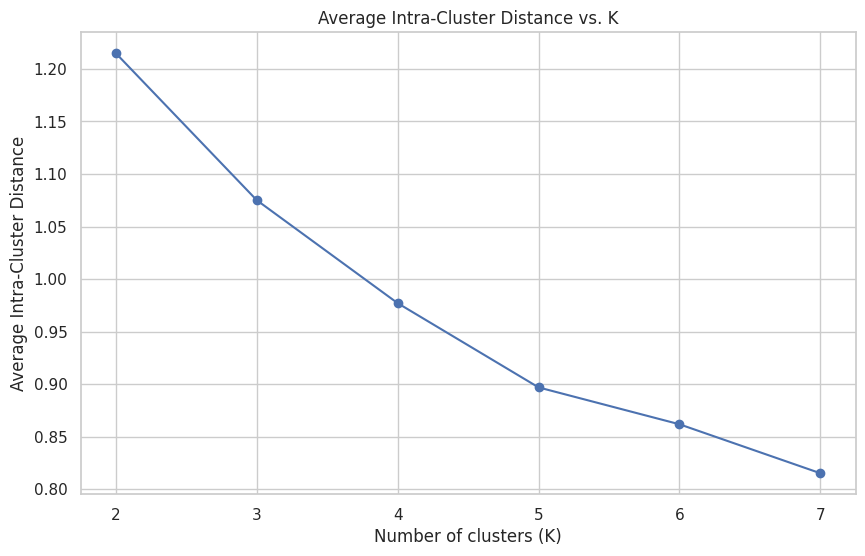

In [ ]:
# 1. Average Intra-Cluster Distance vs. K
intra_distances = [stats['Average Intra-cluster Distance'] for k, stats in statistics.items()]
plt.figure(figsize=(10, 6))
plt.plot(range(2, 8), intra_distances, marker='o')
plt.title("Average Intra-Cluster Distance vs. K")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Average Intra-Cluster Distance")
plt.show()

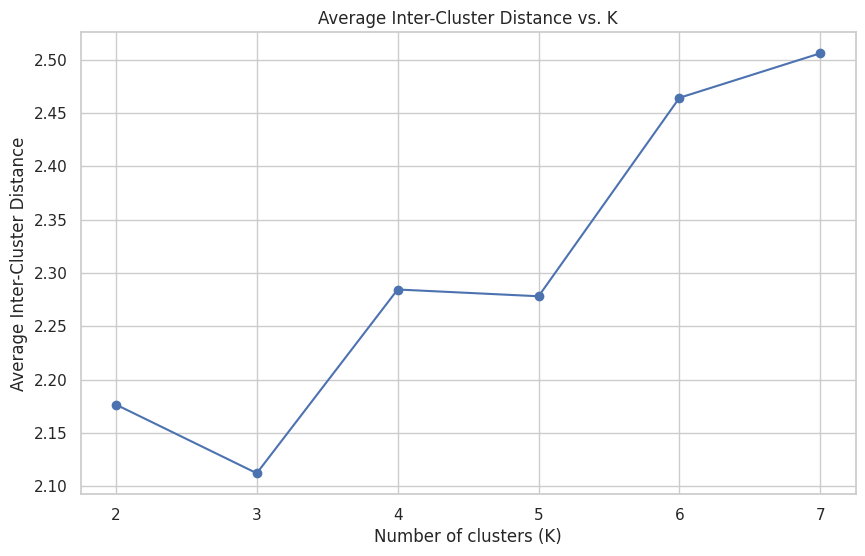

In [ ]:
# 2. Average Inter-Cluster Distance vs. K
inter_distances = [stats['Average Inter-cluster Distance'] for k, stats in statistics.items()]
plt.figure(figsize=(10, 6))
plt.plot(range(2, 8), inter_distances, marker='o')
plt.title("Average Inter-Cluster Distance vs. K")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Average Inter-Cluster Distance")
plt.show()

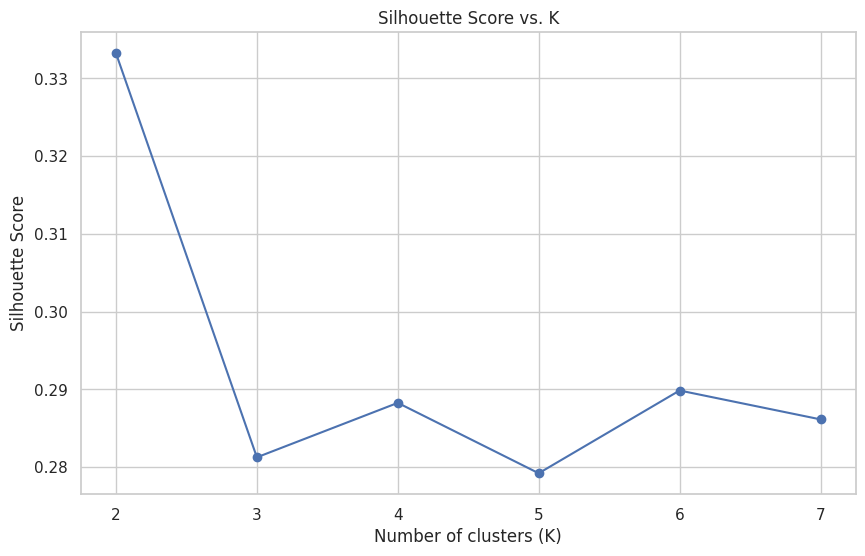

In [ ]:
# 3. Silhouette Score vs. K
sil_scores = [stats['Silhouette Score'] for k, stats in statistics.items()]
plt.figure(figsize=(10, 6))
plt.plot(range(2, 8), sil_scores, marker='o')
plt.title("Silhouette Score vs. K")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()

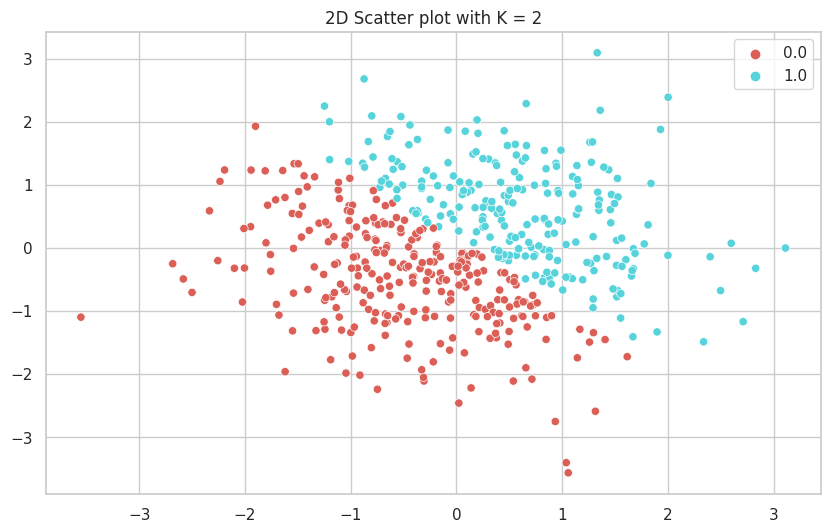

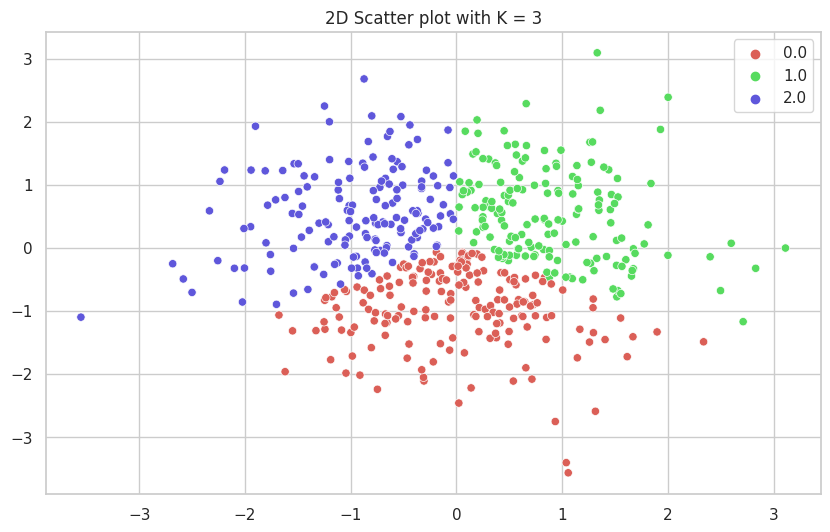

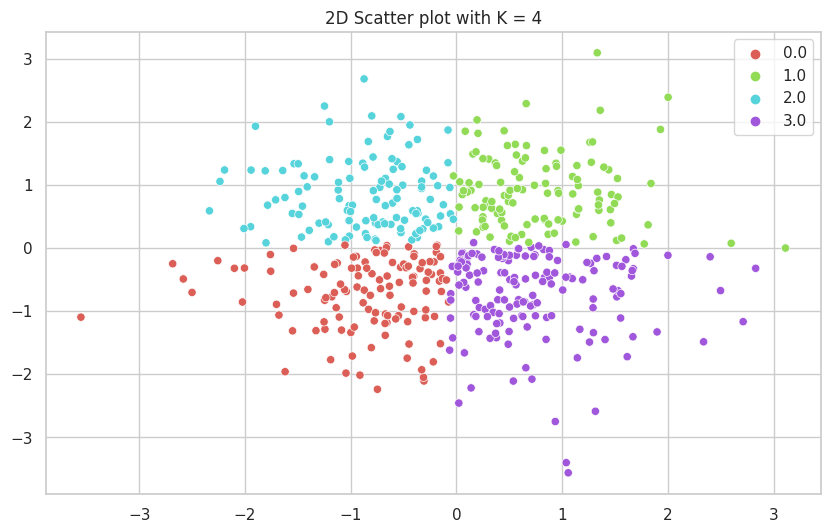

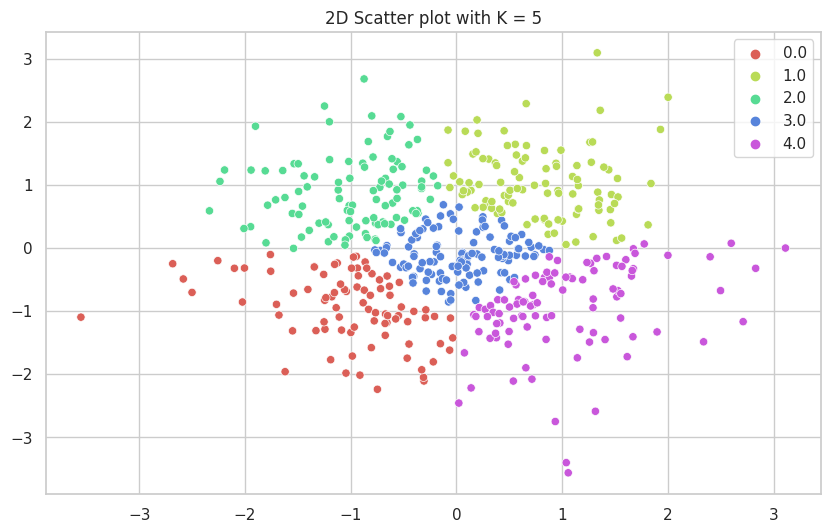

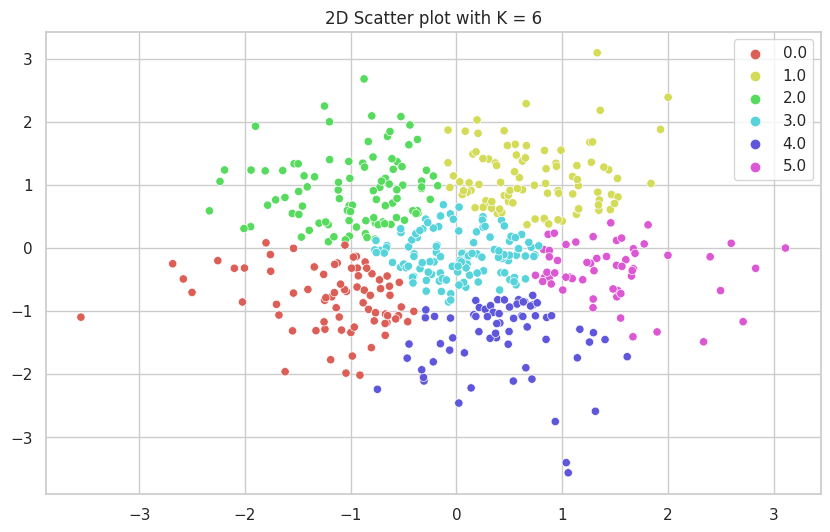

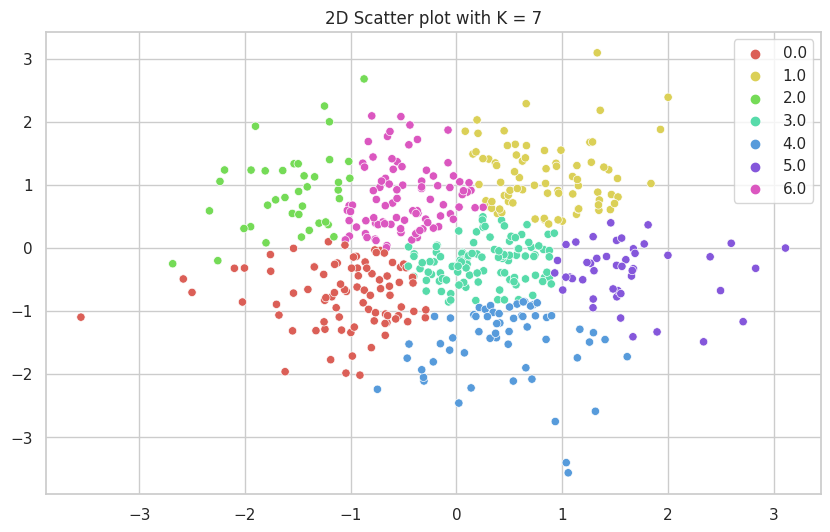

In [ ]:
# 4. 2D Scatter plot of Observations with Clusters
# Assuming df has two features for visualization. If df has more, you might want to choose which features to plot.
for k in range(2, 8):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df_scaled[:, 0], y=df_scaled[:, 1], hue=statistics[k]['Labels'], palette=sns.color_palette("hls", k))
    plt.title(f"2D Scatter plot with K = {k}")
    plt.show()


# **PART B**

In [ ]:
'''
Some possible imports you many find interesting, or not.
'''
import pandas as pd
import numpy as np

import random
import math

import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer


from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score


from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage,dendrogram,cut_tree




***----------Description on the Dataset---------***

This dataset has 23 variables, listed as :
1. age
2. gender
3. security number
4. region category
5. membership
6. joining date
7. joined through referral
8. referral id
9. preferred offer types
10. medium of operation
11. internet option
12. last_visit_time
13. days_since_last_login
14. average time spent
15. average transaction value
16. average frequency login days
17. points in wallet
18. used special discount
19. offer application preference
20. past complaint
21. complaint status
22. feedback
23. churn_risk_score


Generally, there are two objectives of performing clustering.
1. We are interested in finding out whether members of different memberships could be grouped by the given features, or subset of them.
2. discover the characteristics of each cluster to gain insights into customer behaviors to facilitate company's further actions to improve the marketing or retention strategy.




## **Data Preparation**


*** --------  Data Cleaning:-------------**


1. Not every variable is useful in clustering. For example, there are some identifier variables: **security number, referral_id, last_visit_time**. I will deletete those columns,as well as any data points that contain missing values in the features.

2. In the total dataset, there are overall 36992 datapoints. And by a quick check in the excel, there are 5393 data shows up missing values in features **medium of operation**, and 5438 missing values in **joined through referral**, 5428 missing values in feature "**region categories**", and almost 20000+ value loss in the complaint status, indicated as "No applicable", "No Information Available"..which could be considered as a large proportion of data loss. 13000+ users had no feedback. So, I will also remove these five columns.

  And for column **points in the wallet** and **preferred_offer_types** , there are missing values. We delete these missing values.  

3. Also, I dont think 'joining date' is a good feature, as it does not provide a general picture to the customer behaviors and cause difficulty in evaluation. So, I will make a little change to this column, transforming it into a continuous variable: days_since_joining.


In [ ]:
# import the original dataset

# File path
file_path_churn = "/content/drive/MyDrive/share_folders_csc373/Data/churn 2.csv"

# Read the file
df_churn = pd.read_csv(file_path_churn)

# Display the first few rows of the dataframe to confirm
df_churn.head()

,Unnamed: 0,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,0,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,Gift Vouchers/Coupons,...,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,0
1,1,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,Gift Vouchers/Coupons,...,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,0
2,2,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,Gift Vouchers/Coupons,...,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,1
3,3,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,Gift Vouchers/Coupons,...,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,1
4,4,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,Credit/Debit Card Offers,...,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,1


In [ ]:
# Check the number of data points (rows) in the dataset
total_rows = df_churn.shape[0]
print(f"Total number of data points (rows): {total_rows}")

Total number of data points (rows): 36992


In [ ]:
columns_to_drop = ["Unnamed: 0", "security_no", "referral_id", "last_visit_time","joined_through_referral","medium_of_operation","region_category","complaint_status","feedback"]

# Drop the identifier columns
df_churn = df_churn.drop(columns=columns_to_drop)

# Display the first few rows of the dataframe to confirm
df_churn.head()


,age,gender,membership_category,joining_date,preferred_offer_types,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,churn_risk_score
0,18,F,Platinum Membership,2017-08-17,Gift Vouchers/Coupons,Wi-Fi,17,300.63,53005.25,17.0,781.75,Yes,Yes,No,0
1,32,F,Premium Membership,2017-08-28,Gift Vouchers/Coupons,Mobile_Data,16,306.34,12838.38,10.0,NaN,Yes,No,Yes,0
2,44,F,No Membership,2016-11-11,Gift Vouchers/Coupons,Wi-Fi,14,516.16,21027.00,22.0,500.69,No,Yes,Yes,1
3,37,M,No Membership,2016-10-29,Gift Vouchers/Coupons,Mobile_Data,11,53.27,25239.56,6.0,567.66,No,Yes,Yes,1
4,31,F,No Membership,2017-09-12,Credit/Debit Card Offers,Mobile_Data,20,113.13,24483.66,16.0,663.06,No,Yes,Yes,1


In [ ]:

# Replace different indicators of missing values with NaN
indicators_of_missing = [' ', '?', 'Error','Unknown']
for indicator in indicators_of_missing:
    df_churn.replace(indicator, np.nan, inplace=True)

# Check for any remaining missing values in the dataset
missing_values = df_churn.isnull().sum()

# Display columns with missing values and their count
print(missing_values[missing_values > 0])

# Delete rows with any missing values
df_churn.dropna(inplace=True)

# Check again for any remaining missing values in the dataset after deletion
missing_values = df_churn.isnull().sum()

# Display columns with missing values and their count, though there should be none after the deletion
print(missing_values[missing_values > 0])



gender                        59
preferred_offer_types        288
avg_frequency_login_days    3522
points_in_wallet            3443
dtype: int64
Series([], dtype: int64)


In [ ]:
# Convert joining_date to datetime format
df_churn['joining_date'] = pd.to_datetime(df_churn['joining_date'])

# Convert joining_date to days since the earliest date
df_churn['days_since_joining'] = (df_churn['joining_date'] - df_churn['joining_date'].min()).dt.days
df_churn.drop(columns=['joining_date'], inplace=True)  # Drop the original joining_date column


In [ ]:
print(df_churn.columns)


Index(['age', 'gender', 'membership_category', 'preferred_offer_types',
       'internet_option', 'days_since_last_login', 'avg_time_spent',
       'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet',
       'used_special_discount', 'offer_application_preference',
       'past_complaint', 'churn_risk_score', 'days_since_joining'],
      dtype='object')


In [ ]:
# Check the number of data points (rows) in the dataset
total_rows = df_churn.shape[0]
print(f"Total number of data points (rows): {total_rows}")

Total number of data points (rows): 36992




*** --------  up to this point, we make sure that there is no missing values in the dataset**, **we then perform categotical variable encoding ------**




Now, we have variables

continuous variables:
1. age
2. days_since_last_login
3. average time spent
4. average transaction value
5. average frequency login days
6. points in wallet
7. joining_date

nominal categorical variables:
1. preferred offer types
2. internet option
3. gender
4. used special discount
5. offer application preference
6. past complaint
7. churn_risk_score

For clustering, it's important to ensure that categorical variables are properly encoded so that the model can understand and process them.for ordinal data, I will use one-hot encoding.

And I will also do the scaling for all the variables.


In [ ]:
# One-Hot Encoding
df_churn = pd.get_dummies(df_churn, columns=[
    'preferred_offer_types',
    'internet_option',
    'gender',
    'used_special_discount',
    'offer_application_preference',
    'past_complaint',
    'churn_risk_score'
])


In [ ]:
# List of columns NOT to scale
# membership_categoy is the evaluation features, so we would want to keep it as the same.
columns_not_to_scale = ['membership_category']

# List of columns to scale
columns_to_scale = df_churn.columns.difference(columns_not_to_scale)

scaler = StandardScaler()

# Create a new dataframe for the scaled data
df_churn_scale = df_churn.copy()
df_churn_scale[columns_to_scale] = scaler.fit_transform(df_churn[columns_to_scale])


In [ ]:
print(df_churn_scale.head())

        age  membership_category  days_since_last_login  avg_time_spent  \
0 -1.202493  Platinum Membership               0.259139        0.142886   
2  0.433687        No Membership               0.246115        0.685875   
3 -0.006823        No Membership               0.233091       -0.480292   
4 -0.384403        No Membership               0.272163       -0.329486   
5 -1.517143      Gold Membership               0.285187        0.477930   

   avg_transaction_value  avg_frequency_login_days  points_in_wallet  \
0               1.225998                  0.111630          0.485147   
2              -0.422907                  0.654521         -0.958681   
3              -0.205693                 -1.082731         -0.614651   
4              -0.244670                  0.003051         -0.124573   
5              -0.791184                  0.871678          0.179593   

   days_since_joining  preferred_offer_types_Credit/Debit Card Offers  \
0            1.291903                      

# K-Means


*** --------  Decide on which subset of features to fit the models ------**




First, We try the built-in function kmean.fit, and draw out the SSE and sihoueete scores of using different k values.
And then, we compare it with the results obtained by using the custom kmeans function.

The first subset includes five variabels "past_complaint_No","past_complaint_Yes","days_since_last_login", "preferred_offer_types_Credit/Debit Card Offers", "preferred_offer_types_Gift Vouchers/Coupons".

SSE has a significant drop at K = 7, and silhouette score approaches to 0.9. K= 7 is a relatively small number,so it is time efficient.  I consider this subset to be a good choice to fit the model.
However, I think churn_risk_score is also an important indicator. So I will test on another subset with churn_risk_score included.

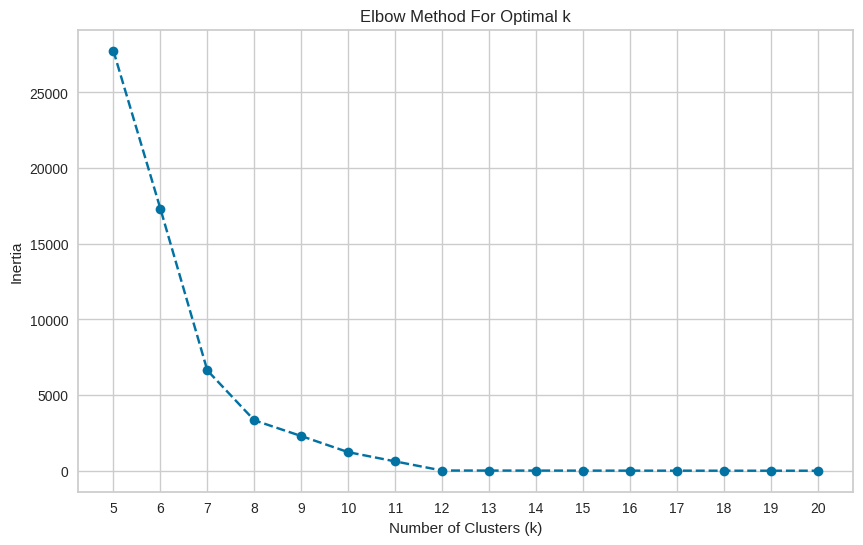

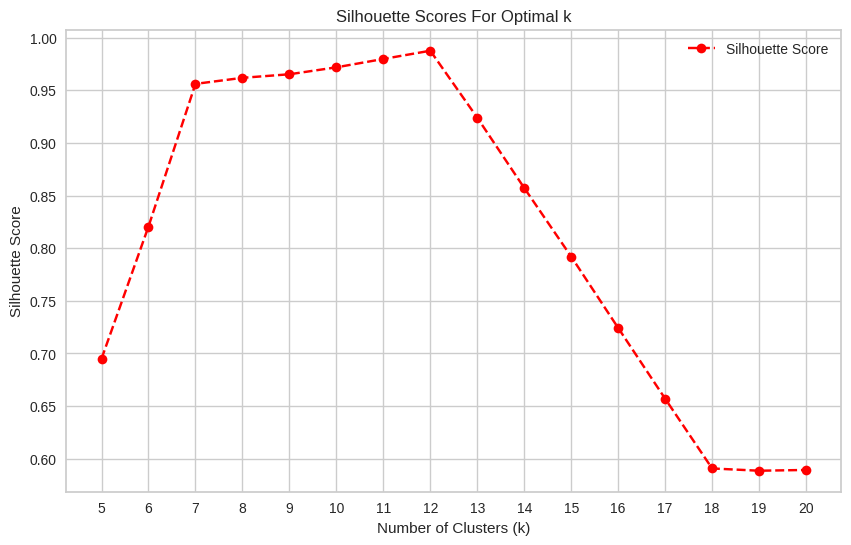

In [ ]:
# 1. Extract the desired columns
selected_features = ["past_complaint_No","past_complaint_Yes",
                     "days_since_last_login",
                     "preferred_offer_types_Credit/Debit Card Offers",
                     "preferred_offer_types_Gift Vouchers/Coupons"
                  ]
df_selected = df_churn_scale[selected_features]

# 2. Elbow Method to determine optimal k
inertia_list = []
silhouette_scores = [] # Initialize the silhouette_scores list here
for k in range(5, 21):
    kmeans = KMeans(n_clusters=k, n_init=1, random_state=42)
    kmeans.fit(df_selected)
    inertia_list.append(kmeans.inertia_)


    # Calculate the Silhouette Score for this k value
    silhouette_avg = silhouette_score(df_selected, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)


plt.figure(figsize=(10, 6))
plt.plot(range(5, 21), inertia_list, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(5, 21))
plt.grid(True)
plt.show()

# 4. Plot Silhouette Scores graph
plt.figure(figsize=(10, 6))
plt.plot(range(5, 21), silhouette_scores, marker='o', linestyle='--', color='red', label='Silhouette Score')
plt.title('Silhouette Scores For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(5, 21))
plt.grid(True)
plt.legend()
plt.show()





The second subset I tested on has 7 variables : "past_complaint_No","past_complaint_Yes", "days_since_last_login", "preferred_offer_types_Credit/Debit Card Offers","preferred_offer_types_Gift Vouchers/Coupons""churn_risk_score_0","churn_risk_score_1".

The elbow point is around K = 12. And when K = 12, we achieve relatively small SSE and great silhouette score.

 ** --------- So I will continue the evluation using the second subset ---**

In [ ]:
# 1. Extract the desired columns
selected_features = ["past_complaint_No","past_complaint_Yes",
                     "days_since_last_login",
                     "preferred_offer_types_Credit/Debit Card Offers",
                     "preferred_offer_types_Gift Vouchers/Coupons",
                     "churn_risk_score_0","churn_risk_score_1"
                  ]
df_selected = df_churn_scale[selected_features]

Silhouette Score for k=5: 0.397
Silhouette Score for k=6: 0.461
Silhouette Score for k=7: 0.561
Silhouette Score for k=8: 0.626
Silhouette Score for k=9: 0.679
Silhouette Score for k=10: 0.753
Silhouette Score for k=11: 0.826
Silhouette Score for k=12: 0.831
Silhouette Score for k=13: 0.893
Silhouette Score for k=14: 0.953
Silhouette Score for k=15: 0.952
Silhouette Score for k=16: 0.958
Silhouette Score for k=17: 0.963
Silhouette Score for k=18: 0.965
Silhouette Score for k=19: 0.968
Silhouette Score for k=20: 0.972


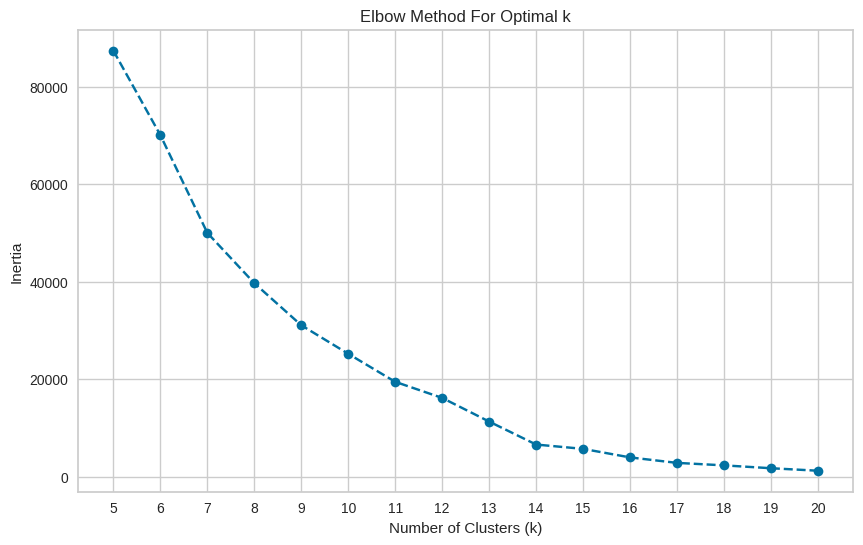

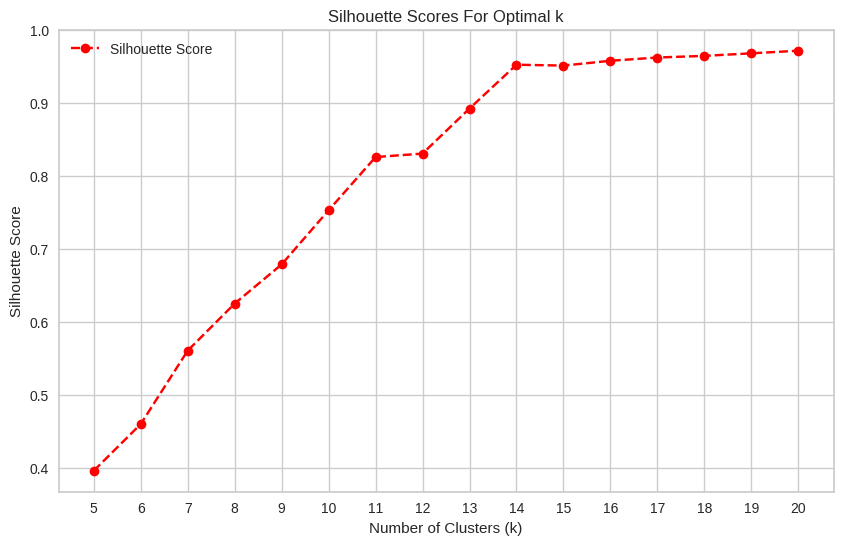

In [ ]:

# 2. Elbow Method to determine optimal k
inertia_list = []
silhouette_scores = [] # Initialize the silhouette_scores list here
for k in range(5, 21):
    kmeans = KMeans(n_clusters=k, n_init=1, random_state=42)
    kmeans.fit(df_selected)
    inertia_list.append(kmeans.inertia_)


    # Calculate the Silhouette Score for this k value
    silhouette_avg = silhouette_score(df_selected, kmeans.labels_)
    print(f"Silhouette Score for k={k}: {silhouette_avg:.3f}")
    silhouette_scores.append(silhouette_avg)


plt.figure(figsize=(10, 6))
plt.plot(range(5, 21), inertia_list, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(5, 21))
plt.grid(True)
plt.show()

# 4. Plot Silhouette Scores graph
plt.figure(figsize=(10, 6))
plt.plot(range(5, 21), silhouette_scores, marker='o', linestyle='--', color='red', label='Silhouette Score')
plt.title('Silhouette Scores For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(5, 21))
plt.grid(True)
plt.legend()
plt.show()





***Now, we will compare the statistics we obtained using the built in function with the custom kmean function. ***

-- Fit the model using the built in Kmeans with K = 12.


Average intra-cluster distance: 0.387
Average inter-cluster distance: 3.994
Silhouette Score for k=14: 0.831

The difference between the silhouette score here and what is shown in the graph might be resulted from the different initial cluster centroid.

In [ ]:
# 1. Fitting KMeans to df_selected with K=12
kmeans = KMeans(n_clusters=12, n_init=1,random_state=42)
kmeans.fit(df_selected)

# 2. Calculate the Silhouette Score
silhouette_avg = silhouette_score(df_selected, kmeans.labels_)

# 3. Calculate average intra-cluster distance

intra_distances = intracluster_dist(df_selected.values, 11, kmeans.labels_, kmeans.cluster_centers_)
avg_intra_distance = np.mean(intra_distances)

# 4. Calculate average inter-cluster distance

inter_distances = [intercluster_dist(cluster_i, cluster_j, kmeans.cluster_centers_)
                   for cluster_i in range(12)
                   for cluster_j in range(cluster_i + 1, 12)]
avg_inter_distance = np.mean(inter_distances)

# 5. Print results
print(f"Average intra-cluster distance: {avg_intra_distance:.3f}")
print(f"Average inter-cluster distance: {avg_inter_distance:.3f}")
print(f"Silhouette Score for k=12: {silhouette_avg:.3f}")


Average intra-cluster distance: 0.387
Average inter-cluster distance: 3.994
Silhouette Score for k=14: 0.831


-- Fit the model using the custom function kmeans_373 with K = 12.

Average intra-cluster distance: 0.700
Average inter-cluster distance: 4.195
Silhouette Score for k=14: 0.746

In [ ]:
# 1. Fitting custom KMeans to df_selected with K=12
initial_centers = df_selected.sample(n=12, random_state=42).values  # Randomly initializing cluster centers
final_centers, cluster_assignments = k_means_373(df_selected, 12, initial_centers)

# 2. Calculate the Silhouette Score
silhouette_avg = silhouette_score(df_selected, cluster_assignments)

# 3. Calculate average intra-cluster distance using the custom function
intra_distances = intracluster_dist(df_selected.values, 12, cluster_assignments, final_centers)
avg_intra_distance = np.mean(intra_distances)

# 4. Calculate average inter-cluster distance using the custom function
inter_distances = [intercluster_dist(cluster_i, cluster_j, final_centers)
                   for cluster_i in range(12)
                   for cluster_j in range(cluster_i + 1, 12)]
avg_inter_distance = np.mean(inter_distances)

# 5. Print results
print(f"Average intra-cluster distance: {avg_intra_distance:.3f}")
print(f"Average inter-cluster distance: {avg_inter_distance:.3f}")
print(f"Silhouette Score for k=14: {silhouette_avg:.3f}")


Average intra-cluster distance: 0.700
Average inter-cluster distance: 4.195
Silhouette Score for k=14: 0.746


Conclusion on the comparison between built in Kmeans and custom function Kmean-373.

Three statistics (average intra-cluster distance, average inter-cluster distance, silhouette score) obtained by fitting with two kmean methods are similar, with the built in Kmean slightly better performed.

Considering that built in Kmeans is also more time efficient. I will choose built in Kmeans algorithm with K = 12 to train the model.

*** ---------- train the model and store all training data and the clustering result in a new dataset with the original dataset df_churn----------- ***

In [ ]:
from sklearn.cluster import KMeans

# Create a copy of df_selected
df_k_clustered = df_selected.copy()

# Initializing the KMeans object
kmeans = KMeans(n_clusters=12, random_state=42)

# Fitting the model and predicting cluster assignments
df_k_clustered['cluster'] = kmeans.fit_predict(df_k_clustered)

# Adding 'membership_type' to the copied dataframe
df_k_clustered['membership_type'] = df_churn_scale['membership_category']

# Now, df_selected remains unchanged, and df_clustered contains the clustering results and 'membership_type'.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


*** --------- visualization of the results in 2D plot ---------- ***

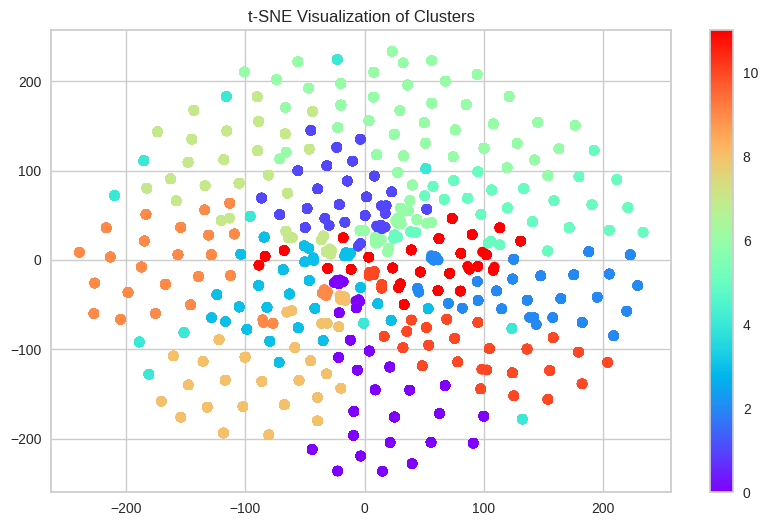

In [ ]:


tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df_clustered.drop(["cluster", "membership_type"], axis=1))

plt.figure(figsize=(10,6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df_clustered['cluster'], cmap='rainbow')
plt.title('t-SNE Visualization of Clusters')
plt.colorbar()
plt.show()


# Hierarchical

Same as we did in Kmeans, we test which k is the optimal value in fitting the model based on the silhouette score. K = 12 turns out to be the elbow point. I will then use K = 12 to fit the model.

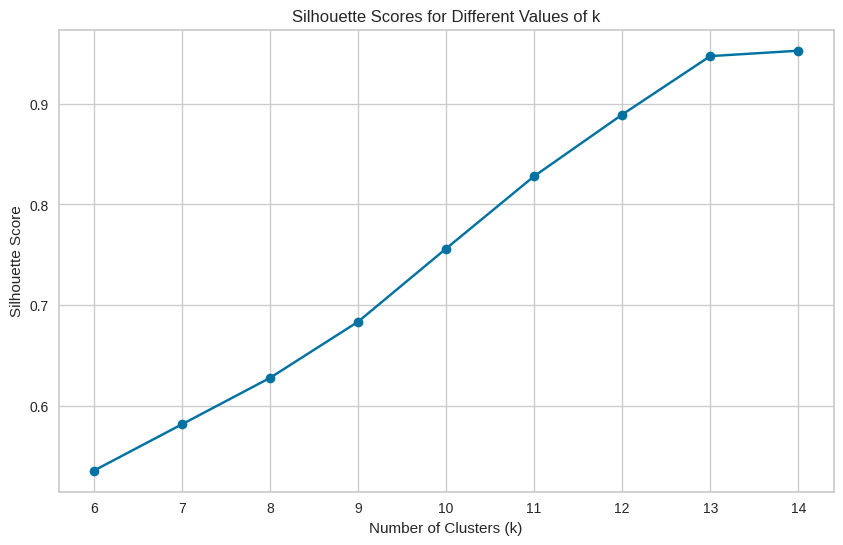

Optimal number of clusters (k) is: 14


In [ ]:


# Compute the linkage matrix
Z = linkage(df_selected, method='ward')

# Range of k values to test
k_values = range(6, 15)  # You can adjust this range
silhouette_scores = []

# Perform hierarchical clustering for each k and evaluate performance
for k in k_values:
    clusters = fcluster(Z, k, criterion='maxclust')
    silhouette_avg = silhouette_score(df_selected, clusters)
    silhouette_scores.append(silhouette_avg)

# Visualize the performance
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different Values of k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Decide on optimal k (highest silhouette score)
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters (k) is: {optimal_k}")


*** --------- store the clustering result into a new dataset.-------  ***

In [ ]:

# Create a copy of df_selected
df_h_clustered = df_selected.copy()

# Initializing the AgglomerativeClustering object
agg_clustering = AgglomerativeClustering(n_clusters=12, affinity='euclidean', linkage='ward')

# Fitting the model and predicting cluster assignments
df_h_clustered['cluster'] = agg_clustering.fit_predict(df_h_clustered)

# Compute the linkage matrix Z using the original data (df_selected)
Z = linkage(df_selected, method='ward', metric='euclidean')

# Adding 'membership_type' to the copied dataframe
df_h_clustered['membership_type'] = df_churn_scale['membership_category']

# Now, df_selected remains unchanged, and df_h_clustered contains the clustering results and 'membership_type'.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


### DBSCAN

***By applying grid search, we found out that the best silhouette score is given at eps = 0.3, min_samples = 5.***

In [ ]:
eps_values = [0.3, 0.5, 0.7, 0.9]
min_samples_values = [5, 10, 15, 20]


from sklearn.metrics import silhouette_score

best_score = -1  # initialize with -1 since Silhouette score ranges from -1 to 1
best_params = None

results = {}

for eps_val in eps_values:
    for min_samples_val in min_samples_values:
        dbscan = DBSCAN(eps=eps_val, min_samples=min_samples_val)
        labels = dbscan.fit_predict(df_selected)

        # Silhouette score is only meaningful when there's more than 1 cluster and less clusters than data points
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters > 1 and n_clusters < len(df_selected) - 1:
            score = silhouette_score(df_selected, labels)
            if score > best_score:
                best_score = score
                best_params = (eps_val, min_samples_val)

            results[(eps_val, min_samples_val)] = score
        else:
            results[(eps_val, min_samples_val)] = None


print(f"Best Silhouette score: {best_score}")
print(f"Best parameters: eps = {best_params[0]}, min_samples = {best_params[1]}")


Best Silhouette score: 0.9876543506377055
Best parameters: eps = 0.3, min_samples = 5


***We then fit the DBSCAN model using Best parameters: eps = 0.3, min_samples = 5 and store the clsutering result into a new dataset. ***

In [ ]:
# Create a copy of df_selected for storing the DBSCAN results
df_dbscan_clustered = df_selected.copy()

# Initialize the DBSCAN model with specified parameters
dbscan = DBSCAN(eps=0.3, min_samples=5)

# Fit the model and predict cluster assignments
# Note: DBSCAN labels noise points as -1
df_dbscan_clustered['cluster'] = dbscan.fit_predict(df_dbscan_clustered)

# Add 'membership_type' to the copied dataframe
df_dbscan_clustered['membership_type'] = df_churn_scale['membership_category']

# Now, df_selected remains unchanged, and df_dbscan_clustered contains the clustering results and 'membership_type'.


We now finishes with all the clustering process, and now comes to part C to continue the cluster evaluatin and analysis.

The cophenet function is resource-intensive, especially if the dataset (df_selected) is large. Everytime I run the function, it causes a crash.

So I will look at the silouette score as the internal evaluation method for three approaches and ARI as the external evaluation method.

# ***PART C***

In [ ]:

# KMeans Evaluation
kmeans_silhouette = silhouette_score(df_k_clustered.drop(['cluster', 'membership_type'], axis=1), df_k_clustered['cluster'])

# Hierarchical Evaluation
hierarchical_silhouette = silhouette_score(df_h_clustered.drop(['cluster', 'membership_type'], axis=1), df_h_clustered['cluster'])

# DBSCAN Evaluation
# For DBSCAN, you might have noise (-1 label). Depending on the amount of noise, silhouette_score might be less insightful.
dbscan_silhouette = silhouette_score(df_dbscan_clustered[df_dbscan_clustered['cluster'] != -1].drop(['cluster', 'membership_type'], axis=1), df_dbscan_clustered[df_dbscan_clustered['cluster'] != -1]['cluster'])

print(f"KMeans Silhouette Score: {kmeans_silhouette:.2f}")
print(f"Hierarchical Silhouette Score: {hierarchical_silhouette:.2f}")
print(f"DBSCAN Silhouette Score (excluding noise): {dbscan_silhouette:.2f}")


KMeans Silhouette Score: 0.89
Hierarchical Silhouette Score: 0.89
DBSCAN Silhouette Score (excluding noise): 0.99


Based on the evaluation, DBSCAN gives the best result.
Recall to our objectives of the study:

1. finding out whether members of different memberships could be grouped by the given features, or subset of them.
2. discover the characteristics of each cluster to gain insights into customer behaviors to facilitate company's further actions to improve the marketing or retention strategy.


For the first objective, I will give a purity check on each cluster to see whther it gives any implication on the membership or not.


In [ ]:
unique_memberships = df_churn_scale['membership_category'].unique()
num_unique_memberships = len(unique_memberships)

print(f"There are {num_unique_memberships} unique names in the 'membership' variable.")
print(unique_memberships)


There are 6 unique names in the 'membership' variable.
['Platinum Membership' 'No Membership' 'Gold Membership'
 'Basic Membership' 'Silver Membership' 'Premium Membership']


In [ ]:
# Assuming 'df_churn' and 'df_dbscan_clustered' are aligned by index

# Add the 'cluster' column from 'df_dbscan_clustered' to 'df_churn'
df_churn['cluster'] = df_dbscan_clustered['cluster']

# Now you can group by 'cluster' and compute the count of each 'membership_type' within each cluster
grouped_churn = df_churn.groupby('cluster')['membership_category'].value_counts().unstack().fillna(0)
print(grouped_churn)


def compute_purity(grouped_df):
    # Find the maximum value in each cluster
    max_counts = grouped_df.max(axis=1)

    # Find the sum of data points in each cluster
    total_counts = grouped_df.sum(axis=1)

    # Compute purity for each cluster
    cluster_purities = max_counts / total_counts

    # Compute overall purity (weighted average)
    overall_purity = sum(max_counts) / sum(total_counts)

    return cluster_purities, overall_purity

# Calculate purity for DBSCAN clusters
# Compute purity using the previously defined function
cluster_purities_churn, overall_purity_churn = compute_purity(grouped_churn)
print("Purity for each cluster in df_churn:", cluster_purities_churn)
print("Overall purity in df_churn:", overall_purity_churn)


membership_category  Basic Membership  Gold Membership  No Membership  \
cluster                                                                 
0                                34.0            597.0           34.0   
1                               910.0            324.0          915.0   
2                               991.0            306.0          965.0   
3                                25.0            607.0           35.0   
4                               885.0            311.0          949.0   
5                                59.0             14.0           67.0   
6                                34.0            487.0           24.0   
7                              1002.0            367.0          986.0   
8                                25.0            529.0           28.0   
9                               936.0            295.0          949.0   
10                               40.0            534.0           32.0   
11                              978.0            33

 overall, the purity performance is decent, given that we have 6 classes in 'membership_category'. If we do a random guessing, the purity will be around 0.167. Achieving a purity of 0.4 means that the dominant class in a given cluster makes up 40% of the cluster's data points. This is significantly better than the 16.67% you'd expect from random assignment. It shows that the clustering algorithm is picking up some structure in the data related to the classes.


 But considering that 'membership' does not have to be the primary customer segmentation factor,
 I would like to take a deeper look some interested features of each cluster see the possible concentration of other features.

 We will first have a look at the dataset, which contains the original dataset and the new added columns which cluster each data point belongs to.

In [ ]:
print (df_churn.head())

   age  membership_category  days_since_last_login  avg_time_spent  \
0   18  Platinum Membership                     17          300.63   
2   44        No Membership                     14          516.16   
3   37        No Membership                     11           53.27   
4   31        No Membership                     20          113.13   
5   13      Gold Membership                     23          433.62   

   avg_transaction_value avg_frequency_login_days  points_in_wallet  \
0               53005.25                     17.0            781.75   
2               21027.00                     22.0            500.69   
3               25239.56                      6.0            567.66   
4               24483.66                     16.0            663.06   
5               13884.77                     24.0            722.27   

   days_since_joining  preferred_offer_types_Credit/Debit Card Offers  \
0                 959                                               0   
2     

In [ ]:
# Count of each class in 'membership_category'
membership_category_counts = df_churn['membership_category'].value_counts()
print("Counts for each membership category class:")
print(membership_category_counts)

Counts for each membership category class:
No Membership          6278
Basic Membership       6244
Gold Membership        5506
Silver Membership      4894
Premium Membership     3622
Platinum Membership    3525
Name: membership_category, dtype: int64


We will first look at the distribution of membership_category.

From the statistics, we can see that cluster 0/3/6/8/10/12 has a high number of Premium and Platinum membership users, which indicates that these clusters contain the most loyal or high-value customers.

And cluster 1/ 2/ 7/ 9 has users mostly centered at 'no membership' and 'basic membership' categories.

We will take a look at other features of these two groups of clusters to see how user behaviors are related to memberships.

In [ ]:
# List all possible membership categories
all_categories = ["No Membership", "Basic Membership", "Gold Membership",
                  "Silver Membership", "Premium Membership", "Platinum Membership"]

# Get all unique clusters in the dataframe
unique_clusters = df_churn['cluster'].unique()

# Analyze membership_category distribution within each cluster
for cluster in unique_clusters:
    print(f"\nCluster {cluster} Membership Category Distribution:")
    cluster_data = df_churn[df_churn['cluster'] == cluster]

    # Initialize a Series with zeros for all categories
    category_counts = pd.Series(index=all_categories, data=0)

    # Update the counts with the actual counts from the cluster_data
    category_counts.update(cluster_data['membership_category'].value_counts())

    print(category_counts)



Cluster 0 Membership Category Distribution:
No Membership           34
Basic Membership        34
Gold Membership        597
Silver Membership      485
Premium Membership     620
Platinum Membership    565
dtype: int64

Cluster 1 Membership Category Distribution:
No Membership          915
Basic Membership       910
Gold Membership        324
Silver Membership      306
Premium Membership       0
Platinum Membership      0
dtype: int64

Cluster 2 Membership Category Distribution:
No Membership          965
Basic Membership       991
Gold Membership        306
Silver Membership      327
Premium Membership       0
Platinum Membership      0
dtype: int64

Cluster 3 Membership Category Distribution:
No Membership           35
Basic Membership        25
Gold Membership        607
Silver Membership      462
Premium Membership     592
Platinum Membership    586
dtype: int64

Cluster 4 Membership Category Distribution:
No Membership          949
Basic Membership       885
Gold Membership      

High Loyalty Clusters (Premium and Platinum Memberships)
For clusters 0/3/6/8/10/12, I would explore the following:


1. Demographic:

we would like to look into the age variable. There is no big difference between the age in high loyalty group and the average age across all data points.

In [ ]:
# Define the clusters of interest for low loyalty
high_loyalty_clusters = [0,3,6,8,10,12]

# Filter the DataFrame to include only the low loyalty clusters
high_loyalty_data = df_churn[df_churn['cluster'].isin(high_loyalty_clusters)]

In [ ]:

# Calculate the average age spent for each cluster
average_age = high_loyalty_data.groupby('cluster')['age'].mean()

# Print the average time spent of each cluster
print("Averageage of High Loyalty Cluster:")
print(average_age)


Averageage of High Loyalty Cluster:
cluster
0     37.449679
3     36.788036
6     36.872746
8     36.671484
10    37.203810
12    37.118871
Name: age, dtype: float64


In [ ]:
# Calculate the overall average time spent across all data points
overall_average_age = df_churn['age'].mean()

# Print the overall average time spent
print("Overall Average age all data points:")
print(overall_average_age)

Overall Average age all data points:
37.108417306860886


2. Gender - not a big difference in gender.

In [ ]:

# Calculate the percentage of males in each high loyalty cluster
male_percentage_per_cluster = high_loyalty_data.groupby('cluster')['gender_M'].mean() * 100

# Calculate the percentage of females in each high loyalty cluster by subtracting males percentage from 100%
female_percentage_per_cluster = 100 - male_percentage_per_cluster

# Calculate the overall percentage of males across all data points
overall_male_percentage = df_churn['gender_M'].mean() * 100

# Calculate the overall percentage of females across all data points by subtracting male percentage from 100%
overall_female_percentage = 100 - overall_male_percentage

# Print the gender percentage per high loyalty cluster
print("Gender Percentage per High Loyalty Cluster:")
for cluster in high_loyalty_clusters:
    print(f"Cluster {cluster}: Male: {male_percentage_per_cluster[cluster]:.2f}%, Female: {female_percentage_per_cluster[cluster]:.2f}%")

# Print the overall gender percentage across all data points
print("\nOverall Gender Percentage across all data points:")
print(f"Male: {overall_male_percentage:.2f}%, Female: {overall_female_percentage:.2f}%")


Gender Percentage per High Loyalty Cluster:
Cluster 0: Male: 51.26%, Female: 48.74%
Cluster 3: Male: 48.11%, Female: 51.89%
Cluster 6: Male: 50.28%, Female: 49.72%
Cluster 8: Male: 49.61%, Female: 50.39%
Cluster 10: Male: 50.86%, Female: 49.14%
Cluster 12: Male: 50.14%, Female: 49.86%

Overall Gender Percentage across all data points:
Male: 49.77%, Female: 50.23%


**User engagement:**

1. Loyalty group indicates a higher points in the wallet.

In [ ]:

# Calculate the average time spent for each cluster
average_points = high_loyalty_data.groupby('cluster')['points_in_wallet'].mean()

# Print the average time spent of each cluster
print("Average points per High Loyalty Cluster:")
print(average_points)


Average points per High Loyalty Cluster:
cluster
0     752.805040
3     756.288603
6     753.873077
8     754.830578
10    752.264444
12    748.563836
Name: points_in_wallet, dtype: float64


In [ ]:
# Calculate the overall average time spent across all data points
overall_points = df_churn['points_in_wallet'].mean()

# Print the overall average time spent
print("Overall Average points across all data points:")
print(overall_points)


Overall Average points across all data points:
687.3098427133613


2. Loyalty group has a higher trasaction value

In [ ]:

# Calculate the average time spent for each cluster
average_transaction_value= high_loyalty_data.groupby('cluster')['avg_transaction_value'].mean()

# Print the average time spent of each cluster
print("Average transaction value per High Loyalty Cluster:")
print(average_transaction_value)


Average transaction value per High Loyalty Cluster:
cluster
0     35329.007713
3     35132.160273
6     31825.027357
8     31822.468858
10    34378.321963
12    33086.178844
Name: avg_transaction_value, dtype: float64


In [ ]:
# Calculate the overall trasaction value across all data points
overall_transaction_value = df_churn['avg_transaction_value'].mean()

# Print the overall transaction value
print("Overall transaction_value across all data points:")
print(overall_transaction_value)


Overall transaction_value across all data points:
29228.694877115966


***User Churn Risk***




For those high loyalty users, the probability of having no churn risk is 100%, which is much large than the probability across dataset, which has prob of 45.89%.

In [ ]:
# Calculate the percentage of no churn risk in each high loyalty cluster
no_risk_percentage_per_cluster = high_loyalty_data.groupby('cluster')['churn_risk_score_0'].mean() * 100

# Calculate the percentage of churn risk in each high loyalty cluster by subtracting no risk percentage from 100%
risk_percentage_per_cluster = 100 - no_risk_percentage_per_cluster

# Calculate the overall percentage of no churn risk across all data points
overall_no_risk_percentage = df_churn['churn_risk_score_0'].mean() * 100

# Calculate the overall percentage of churn risk across all data points by subtracting no risk percentage from 100%
overall_risk_percentage = 100 - overall_no_risk_percentage

# Print the churn risk percentage per high loyalty cluster
print("Churn Risk Score Percentage per High Loyalty Cluster:")
for cluster in high_loyalty_clusters:
    print(f"Cluster {cluster}: No Risk: {no_risk_percentage_per_cluster[cluster]:.2f}%, Has Risk: {risk_percentage_per_cluster[cluster]:.2f}%")

# Print the overall churn risk score percentage across all data points
print("\nOverall Churn Risk Score Percentage across all data points:")
print(f"No Risk: {overall_no_risk_percentage:.2f}%, Has Risk: {overall_risk_percentage:.2f}%")


Churn Risk Score Percentage per High Loyalty Cluster:
Cluster 0: No Risk: 100.00%, Has Risk: 0.00%
Cluster 3: No Risk: 100.00%, Has Risk: 0.00%
Cluster 6: No Risk: 100.00%, Has Risk: 0.00%
Cluster 8: No Risk: 100.00%, Has Risk: 0.00%
Cluster 10: No Risk: 100.00%, Has Risk: 0.00%
Cluster 12: No Risk: 100.00%, Has Risk: 0.00%

Overall Churn Risk Score Percentage across all data points:
No Risk: 45.89%, Has Risk: 54.11%


WE now look into the low loyalty customer group.

In [ ]:
# Define the clusters of interest for low loyalty
low_loyalty_clusters = [1, 2, 7, 9]

# Filter the DataFrame to include only the low loyalty clusters
low_loyalty_data = df_churn[df_churn['cluster'].isin(low_loyalty_clusters)]

Demographic:

1. same as high loyalty customer group, there is no big difference between low loyalty group and whole data points in age and gender.

In [ ]:
# Calculate the average age spent for each cluster
average_age = low_loyalty_data.groupby('cluster')['age'].mean()

# Print the average time spent of each cluster
print("Averageage of low Loyalty Cluster:")
print(average_age)


Averageage of low Loyalty Cluster:
cluster
1    37.186965
2    37.425647
7    36.869679
9    37.309221
Name: age, dtype: float64


In [ ]:

# Calculate the percentage of males in each high loyalty cluster
male_percentage_per_cluster = low_loyalty_data.groupby('cluster')['gender_M'].mean() * 100

# Calculate the percentage of females in each high loyalty cluster by subtracting males percentage from 100%
female_percentage_per_cluster = 100 - male_percentage_per_cluster

# Calculate the overall percentage of males across all data points
overall_male_percentage = df_churn['gender_M'].mean() * 100

# Calculate the overall percentage of females across all data points by subtracting male percentage from 100%
overall_female_percentage = 100 - overall_male_percentage

# Print the gender percentage per high loyalty cluster
print("Gender Percentage per High Loyalty Cluster:")
for cluster in low_loyalty_clusters:
    print(f"Cluster {cluster}: Male: {male_percentage_per_cluster[cluster]:.2f}%, Female: {female_percentage_per_cluster[cluster]:.2f}%")

# Print the overall gender percentage across all data points
print("\nOverall Gender Percentage across all data points:")
print(f"Male: {overall_male_percentage:.2f}%, Female: {overall_female_percentage:.2f}%")


Gender Percentage per High Loyalty Cluster:
Cluster 1: Male: 51.16%, Female: 48.84%
Cluster 2: Male: 48.13%, Female: 51.87%
Cluster 7: Male: 50.34%, Female: 49.66%
Cluster 9: Male: 49.24%, Female: 50.76%

Overall Gender Percentage across all data points:
Male: 49.77%, Female: 50.23%


***User Engagement: ***

1. points in the wallet
These low loyalty group has significant lower points in the wallet compared to the average.

In [ ]:
# Calculate the average age spent for each cluster
average_age = low_loyalty_data.groupby('cluster')['age'].mean()

# Print the average time spent of each cluster
print("Averageage of low Loyalty Cluster:")
print(average_age)


# Calculate the overall average time spent across all data points
overall_points = df_churn['points_in_wallet'].mean()

# Print the overall average time spent
print("Overall Average points across all data points:")
print(overall_points)


Averageage of low Loyalty Cluster:
cluster
1    37.186965
2    37.425647
7    36.869679
9    37.309221
Name: age, dtype: float64
Overall Average points across all data points:
687.3098427133613


2. transaction value

the avearage transaction value in low loyalty clsuters is around 25000, while the average across all the data points is around 29000.

In [ ]:
average_transaction_value= low_loyalty_data.groupby('cluster')['avg_transaction_value'].mean()

# Print the average time spent of each cluster
print("Average transaction value per low Loyalty Cluster:")
print(average_transaction_value)

overall_transaction_value = df_churn['avg_transaction_value'].mean()

# Print the overall average time spent
print("Overall transaction_value across all data points:")
print(overall_transaction_value)

Average transaction value per low Loyalty Cluster:
cluster
1    25398.858937
2    25430.096783
7    25857.752177
9    25173.988211
Name: avg_transaction_value, dtype: float64
Overall transaction_value across all data points:
29228.694877115966


3. churn risk

The statistics shows that in all low loyalty clusters, the probability of having churn risk is 100%. The statistics is a little extreme though.

In [ ]:
# Calculate the percentage of no churn risk in each low loyalty cluster
no_risk_percentage_per_cluster = low_loyalty_data.groupby('cluster')['churn_risk_score_0'].mean() * 100

# Calculate the percentage of churn risk in each high loyalty cluster by subtracting no risk percentage from 100%
risk_percentage_per_cluster = 100 - no_risk_percentage_per_cluster

# Calculate the overall percentage of no churn risk across all data points
overall_no_risk_percentage = df_churn['churn_risk_score_0'].mean() * 100

# Calculate the overall percentage of churn risk across all data points by subtracting no risk percentage from 100%
overall_risk_percentage = 100 - overall_no_risk_percentage

# Print the churn risk percentage per low loyalty cluster
print("Churn Risk Score Percentage per low Loyalty Cluster:")
for cluster in low_loyalty_clusters:
    print(f"Cluster {cluster}: No Risk: {no_risk_percentage_per_cluster[cluster]:.2f}%, Has Risk: {risk_percentage_per_cluster[cluster]:.2f}%")

# Print the overall churn risk score percentage across all data points
print("\nOverall Churn Risk Score Percentage across all data points:")
print(f"No Risk: {overall_no_risk_percentage:.2f}%, Has Risk: {overall_risk_percentage:.2f}%")


Churn Risk Score Percentage per low Loyalty Cluster:
Cluster 1: No Risk: 0.00%, Has Risk: 100.00%
Cluster 2: No Risk: 0.00%, Has Risk: 100.00%
Cluster 7: No Risk: 0.00%, Has Risk: 100.00%
Cluster 9: No Risk: 0.00%, Has Risk: 100.00%

Overall Churn Risk Score Percentage across all data points:
No Risk: 45.89%, Has Risk: 54.11%


**Market hints to the product: **

The company can create personalized marketing campaigns to target each group based on their behavior. For the high loyalty group, they can focus on retention strategies and cross-selling or up-selling higher-value products. For the low loyalty group, strategies could focus on increasing engagement and trust, possibly through welcome offers or educational content about the brand’s value.


1. And when we check the percentrage use of the special discount, the data shows that the use rate is relatively similar across high loyalty users and low loyalty users. It suggest that the discount strategy is not effectively differentiated to cater to the distinct needs or preferences of these two groups. The company may need to consider other effective approach, specifically targeted to for example , low loyalty group, to boost the sell and reduce churn risk.

In [ ]:
# Calculate the percentage of no special discount used in each cluster
no_special_discount_percentage_per_cluster = high_loyalty_data.groupby('cluster')['used_special_discount_No'].mean() * 100

# Since 1 indicates no special discount used, you calculate the percentage of used special discounts by subtracting from 100%
used_special_discount_percentage_per_cluster = 100 - no_special_discount_percentage_per_cluster

# Calculate the overall percentage of no special discounts used across all data points
overall_no_special_discount_percentage = high_loyalty_data['used_special_discount_No'].mean() * 100

# Calculate the overall percentage of used special discounts across all data points by subtracting from 100%
overall_used_special_discount_percentage = 100 - overall_no_special_discount_percentage

# Print the no special discount used percentage per cluster
print("No Special Discount Used Percentage per Cluster:")
for cluster in sorted(high_loyalty_data['cluster'].unique()):
    print(f"Cluster {cluster}: No Special Discount: {no_special_discount_percentage_per_cluster.loc[cluster]:.2f}%, Used Special Discount: {used_special_discount_percentage_per_cluster.loc[cluster]:.2f}%")

# Print the overall percentage of no special discounts used across all data points
print("\nOverall Percentage of No Special Discounts Used across all data points:")
print(f"No Special Discounts Used: {overall_no_special_discount_percentage:.2f}%, Used Special Discounts: {overall_used_special_discount_percentage:.2f}%")


No Special Discount Used Percentage per Cluster:
Cluster 0: No Special Discount: 42.14%, Used Special Discount: 57.86%
Cluster 3: No Special Discount: 44.34%, Used Special Discount: 55.66%
Cluster 6: No Special Discount: 42.97%, Used Special Discount: 57.03%
Cluster 8: No Special Discount: 43.74%, Used Special Discount: 56.26%
Cluster 10: No Special Discount: 47.36%, Used Special Discount: 52.64%
Cluster 12: No Special Discount: 44.22%, Used Special Discount: 55.78%

Overall Percentage of No Special Discounts Used across all data points:
No Special Discounts Used: 44.15%, Used Special Discounts: 55.85%


In [ ]:
# Calculate the percentage of no special discount used in each cluster
no_special_discount_percentage_per_cluster = low_loyalty_data.groupby('cluster')['used_special_discount_No'].mean() * 100

# Since 1 indicates no special discount used, you calculate the percentage of used special discounts by subtracting from 100%
used_special_discount_percentage_per_cluster = 100 - no_special_discount_percentage_per_cluster

# Calculate the overall percentage of no special discounts used across all data points
overall_no_special_discount_percentage = low_loyalty_data['used_special_discount_No'].mean() * 100

# Calculate the overall percentage of used special discounts across all data points by subtracting from 100%
overall_used_special_discount_percentage = 100 - overall_no_special_discount_percentage

# Print the no special discount used percentage per cluster
print("No Special Discount Used Percentage per Cluster:")
for cluster in sorted(low_loyalty_data['cluster'].unique()):
    print(f"Cluster {cluster}: No Special Discount: {no_special_discount_percentage_per_cluster.loc[cluster]:.2f}%, Used Special Discount: {used_special_discount_percentage_per_cluster.loc[cluster]:.2f}%")

# Print the overall percentage of no special discounts used across all data points
print("\nOverall Percentage of No Special Discounts Used across all data points:")
print(f"No Special Discounts Used: {overall_no_special_discount_percentage:.2f}%, Used Special Discounts: {overall_used_special_discount_percentage:.2f}%")


No Special Discount Used Percentage per Cluster:
Cluster 1: No Special Discount: 46.35%, Used Special Discount: 53.65%
Cluster 2: No Special Discount: 42.87%, Used Special Discount: 57.13%
Cluster 7: No Special Discount: 46.71%, Used Special Discount: 53.29%
Cluster 9: No Special Discount: 45.15%, Used Special Discount: 54.85%

Overall Percentage of No Special Discounts Used across all data points:
No Special Discounts Used: 45.27%, Used Special Discounts: 54.73%


2. offer types

compared with credit/ debit card offers, high loyalty groups are more willing to be offered with Gift Vouchers/Coupons. So the company may think of this as a hint to improve their promotion strategy.

In [ ]:
# Calculate the average 'preferred_offer_types_Credit/Debit Card Offers' for high loyalty clusters
average_credit_debit_offers = high_loyalty_data['preferred_offer_types_Credit/Debit Card Offers'].mean()

# Print the result
print(f"Average Credit/Debit Card Offers in High Loyalty Clusters: {average_credit_debit_offers:.2f}")


Average Credit/Debit Card Offers in High Loyalty Clusters: 0.34


In [ ]:
# Calculate the average 'preferred_offer_types_Credit/Debit Card Offers' for high loyalty clusters
average_credit_debit_offers = low_loyalty_data['preferred_offer_types_Credit/Debit Card Offers'].mean()

# Print the result
print(f"Average Credit/Debit Card Offers in High Loyalty Clusters: {average_credit_debit_offers:.2f}")


Average Credit/Debit Card Offers in High Loyalty Clusters: 0.50
